# Descriptive Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('space_decay_cleaned.csv')
df.head()

,Unnamed: 0,OBJECT_NAME,OBJECT_ID,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,...,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE
0,0,ARIANE 42P+ DEB,1992-072J,2021-10-31T22:46:50.340864,2.921700,0.652893,7.7156,90.2410,243.1216,38.7796,...,0.0,20668.618,492.864,27784.871,796.095,2,1,FR,1992.0,FRGUI
1,1,SL-8 DEB,1979-028C,2021-10-31T16:32:17.360448,13.754973,0.003072,82.9193,299.1120,158.9093,201.3337,...,0.0,7358.038,104.689,1002.507,957.299,2,0,CIS,1979.0,PKMTR
2,2,GSAT 1,2001-015A,2021-11-01T05:22:43.421952,1.038224,0.023739,12.1717,16.5368,250.1248,146.2900,...,0.0,41197.852,1386.984,35797.696,33841.738,0,2,IND,2001.0,SRI
3,3,CZ-4 DEB,1999-057MB,2021-10-31T11:11:24.198720,14.775907,0.006062,98.4781,8.7205,37.3771,323.1632,...,0.0,7015.076,97.456,679.465,594.417,2,0,PRC,1999.0,TSC
4,4,CZ-4 DEB,1999-057MC,2021-10-31T17:46:46.681248,14.724482,0.006226,98.4232,122.0724,345.1605,27.6061,...,0.0,7031.400,97.796,697.039,609.491,2,0,PRC,1999.0,TSC


## Feature Engineering

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14125 entries, 0 to 14124
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         14125 non-null  int64  
 1   OBJECT_NAME        14125 non-null  object 
 2   OBJECT_ID          14125 non-null  object 
 3   EPOCH              14125 non-null  object 
 4   MEAN_MOTION        14125 non-null  float64
 5   ECCENTRICITY       14125 non-null  float64
 6   INCLINATION        14125 non-null  float64
 7   RA_OF_ASC_NODE     14125 non-null  float64
 8   ARG_OF_PERICENTER  14125 non-null  float64
 9   MEAN_ANOMALY       14125 non-null  float64
 10  NORAD_CAT_ID       14125 non-null  int64  
 11  REV_AT_EPOCH       14125 non-null  int64  
 12  BSTAR              14125 non-null  float64
 13  MEAN_MOTION_DOT    14125 non-null  float64
 14  MEAN_MOTION_DDOT   14125 non-null  float64
 15  SEMIMAJOR_AXIS     14125 non-null  float64
 16  PERIOD             141

### Necessary Adjustments

Epoch -->  2021-10-31T22:46:50.340864 (year-month-day T hour-minute-second-microsecond)  </br>
Launch_Date --> 1992.(year)

In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
df['EPOCH'] = pd.to_datetime(df['EPOCH'])

In [6]:
df = df.sort_values(by=['NORAD_CAT_ID', 'EPOCH']).reset_index(drop=True)

### Feature Extraction 

In [7]:
df['ALTITUDE'] = (df['PERIAPSIS'] + df['APOAPSIS']) / 2
df['ALTITUDE_RANGE'] = df['APOAPSIS'] - df['PERIAPSIS']

In [8]:
df['ORBITAL_PERIOD'] = 2*np.pi*np.sqrt((df['SEMIMAJOR_AXIS']**3) / 398600.4418)

In [9]:
df['APOPERI_RATIO']= df['APOAPSIS']/df['PERIAPSIS']

In [10]:
rcs_to_area = {0:0.05, 1:0.5, 2:5.0}
df['CROSS_SECTIONAL_AREA'] = df['RCS_SIZE'].map(rcs_to_area)
df['DRAG_EFFECTIVE_AREA'] = df['BSTAR']*df['CROSS_SECTIONAL_AREA']

In [11]:
def estimate_decay_time(row):
    if row['PERIAPSIS'] < 150:
        return 0
    else:
        periapsis = max(row['PERIAPSIS'], 150)
        bstar = max(row['BSTAR'], 1e-6)
        size_factor = 1 if row['RCS_SIZE'] == 0 else 1.5 if row['RCS_SIZE'] == 1 else 2

        estimated_time = (periapsis / (bstar * size_factor)) * 0.75
        return min(round(estimated_time), 10000)  # Cap at 10,000 days

df['ESTIMATED_DECAY_EPOCH'] = df.apply(estimate_decay_time, axis=1)
df['EPOCH'] = pd.to_datetime(df['EPOCH'], errors='coerce')

df['ESTIMATED_DECAY_EPOCH'] = df['EPOCH'] + pd.to_timedelta(df['ESTIMATED_DECAY_EPOCH'], unit='D')


In [12]:
df['ORBITAL_DECAY_TIME'] = (df['ESTIMATED_DECAY_EPOCH'] - df['EPOCH']).dt.days

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14125 entries, 0 to 14124
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   OBJECT_NAME            14125 non-null  object        
 1   OBJECT_ID              14125 non-null  object        
 2   EPOCH                  14125 non-null  datetime64[ns]
 3   MEAN_MOTION            14125 non-null  float64       
 4   ECCENTRICITY           14125 non-null  float64       
 5   INCLINATION            14125 non-null  float64       
 6   RA_OF_ASC_NODE         14125 non-null  float64       
 7   ARG_OF_PERICENTER      14125 non-null  float64       
 8   MEAN_ANOMALY           14125 non-null  float64       
 9   NORAD_CAT_ID           14125 non-null  int64         
 10  REV_AT_EPOCH           14125 non-null  int64         
 11  BSTAR                  14125 non-null  float64       
 12  MEAN_MOTION_DOT        14125 non-null  float64       
 13  M

In [16]:
df.columns

Index(['OBJECT_NAME', 'OBJECT_ID', 'EPOCH', 'MEAN_MOTION', 'ECCENTRICITY',
       'INCLINATION', 'RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY',
       'NORAD_CAT_ID', 'REV_AT_EPOCH', 'BSTAR', 'MEAN_MOTION_DOT',
       'MEAN_MOTION_DDOT', 'SEMIMAJOR_AXIS', 'PERIOD', 'APOAPSIS', 'PERIAPSIS',
       'OBJECT_TYPE', 'RCS_SIZE', 'COUNTRY_CODE', 'LAUNCH_DATE', 'SITE',
       'ALTITUDE', 'ALTITUDE_RANGE', 'ORBITAL_PERIOD', 'APOPERI_RATIO',
       'CROSS_SECTIONAL_AREA', 'DRAG_EFFECTIVE_AREA', 'ESTIMATED_DECAY_EPOCH',
       'ORBITAL_DECAY_TIME'],
      dtype='object')

In [44]:
df.to_csv('space_decay_wf.csv', index=False) # space_decay_wf --> wf:with features

In [25]:
numeric_columns = ['MEAN_MOTION', 'ECCENTRICITY','INCLINATION', 'RA_OF_ASC_NODE', 
                    'ARG_OF_PERICENTER', 'MEAN_ANOMALY','REV_AT_EPOCH', 'BSTAR',
                    'MEAN_MOTION_DOT','MEAN_MOTION_DDOT', 'SEMIMAJOR_AXIS', 'PERIOD',
                    'APOAPSIS', 'PERIAPSIS','ALTITUDE', 'ALTITUDE_RANGE', 'ORBITAL_PERIOD',
                    'APOPERI_RATIO','CROSS_SECTIONAL_AREA', 'DRAG_EFFECTIVE_AREA',
                    'ORBITAL_DECAY_TIME']

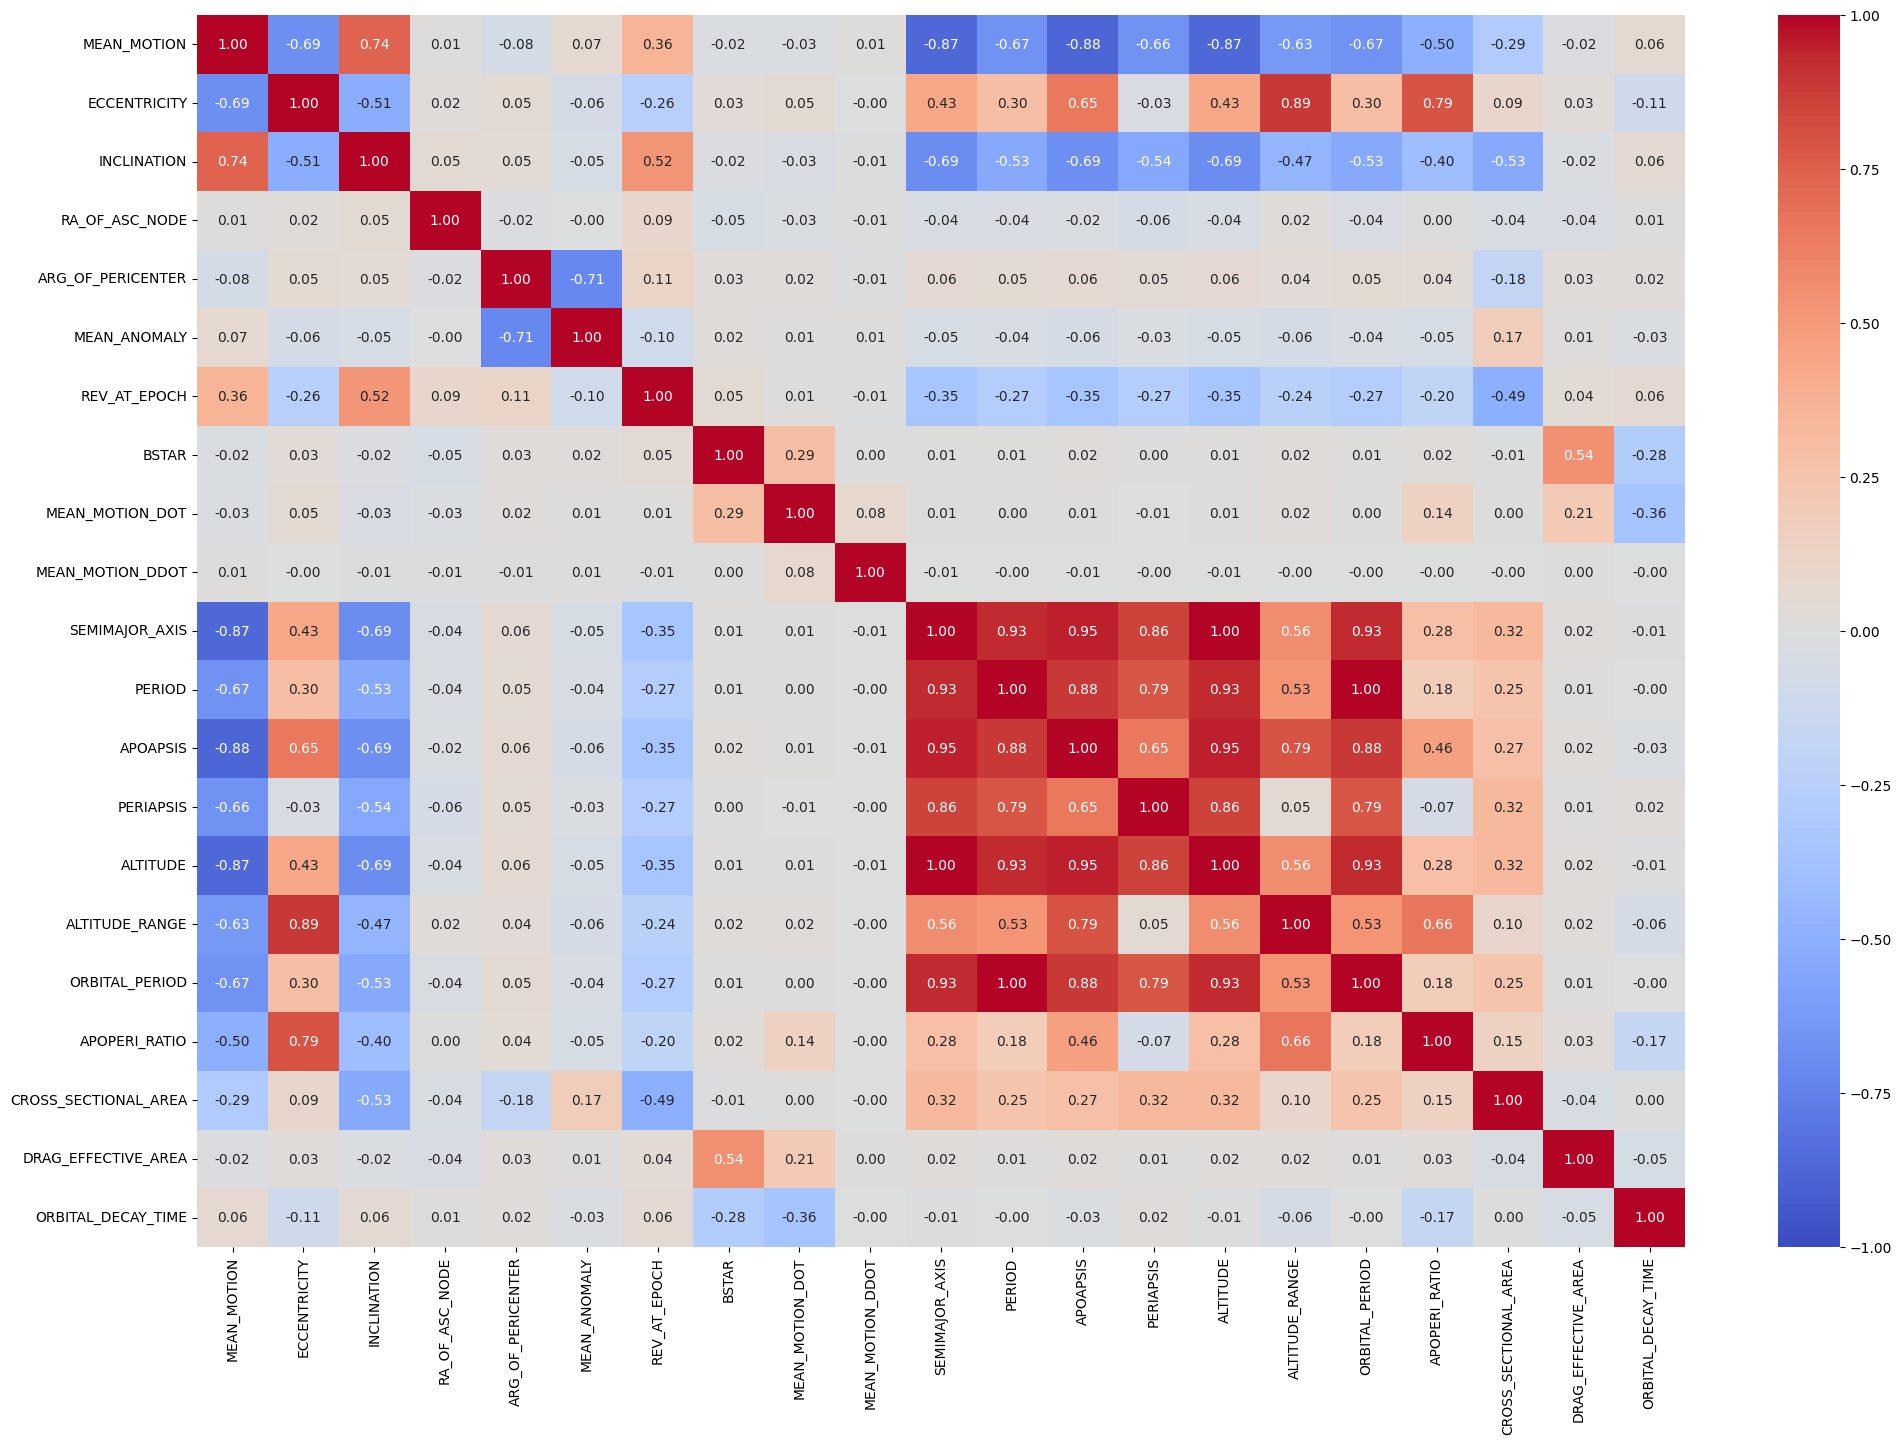

In [26]:
plt.figure(figsize=(24, 16))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm',  fmt=".2f", vmin=-1, vmax=1)
plt.show()

## VIF (Variance Inflation Factor)

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df[numeric_columns].dropna()
vif_df = pd.DataFrame()
vif_df['feature'] = X.columns
vif_df['VIF']=[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


/home/sinem/miniconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [31]:
headers = {
    "selector": "th:not(.index_name)",
    "props": "background-color: #0e2433; color: white; text-align: center;"
}
properties = {"border": "1px solid black", "width": "65px", "text-align": "center"}

vif_df.style.hide(axis="index").set_table_styles([headers]).set_properties(**properties)

feature,VIF
MEAN_MOTION,36.087829
ECCENTRICITY,27.793174
INCLINATION,3.538136
RA_OF_ASC_NODE,1.022045
ARG_OF_PERICENTER,2.084731
MEAN_ANOMALY,2.065921
REV_AT_EPOCH,1.552232
BSTAR,1.601493
MEAN_MOTION_DOT,1.247839
MEAN_MOTION_DDOT,1.008401


/tmp/ipykernel_1423869/830508809.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="feature", data=filtered_vif_df, palette=palette)


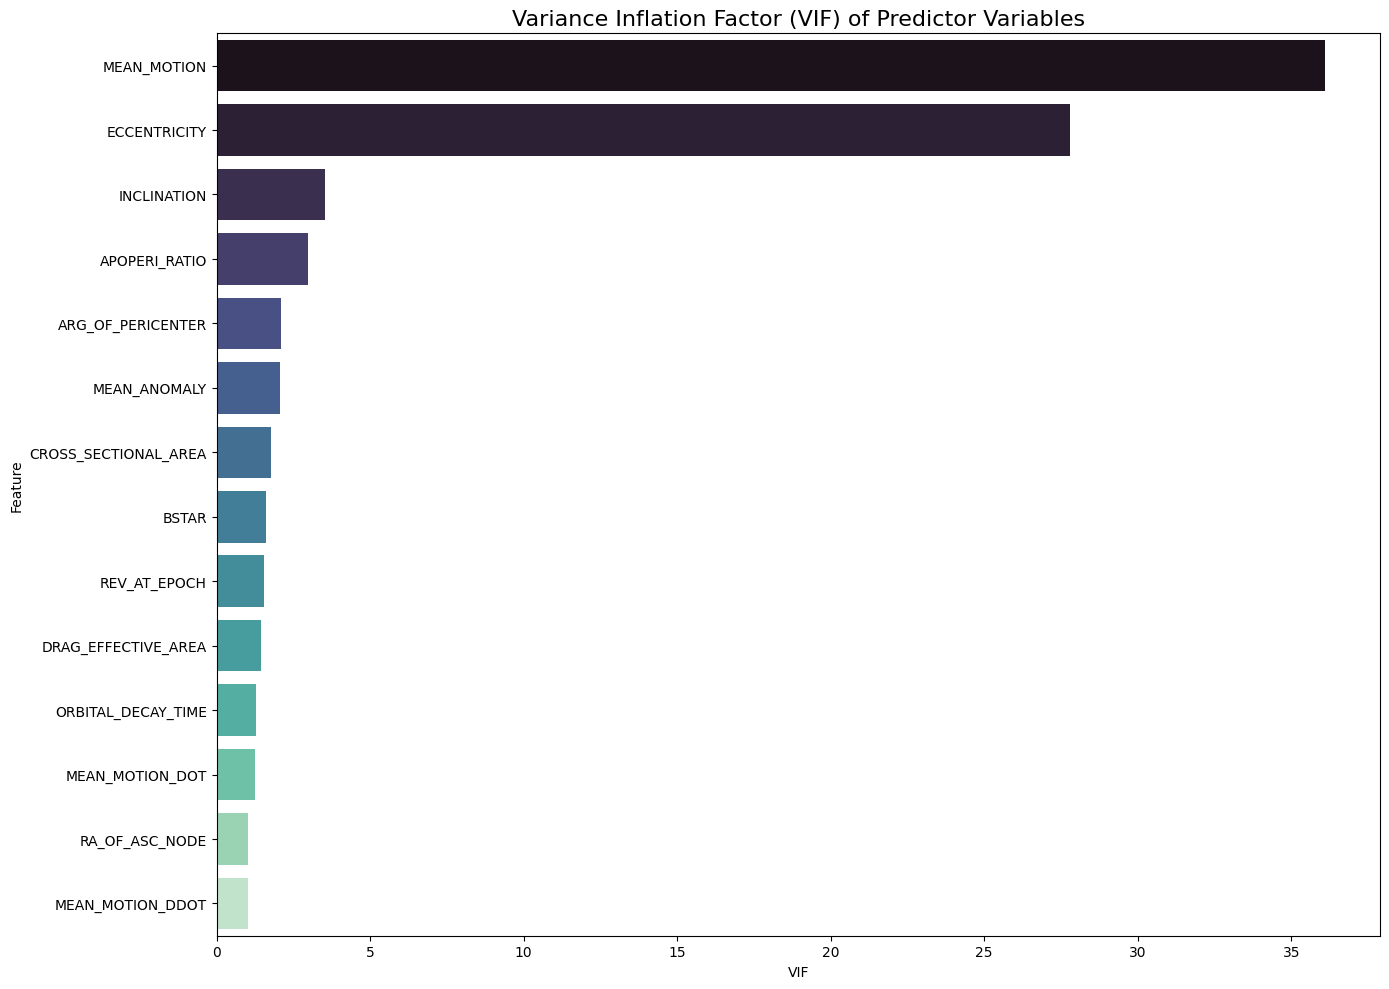

In [33]:
# Filter out infinite or extremely large VIFs
filtered_vif_df = vif_df.copy()
filtered_vif_df = filtered_vif_df.replace([np.inf, -np.inf], np.nan).dropna()
filtered_vif_df = filtered_vif_df[filtered_vif_df["VIF"] < 1000]  # Example threshold

# Sort by VIF
filtered_vif_df = filtered_vif_df.sort_values(by='VIF', ascending=False)

# Visualization
palette = sns.color_palette("mako", n_colors=len(filtered_vif_df))
plt.figure(figsize=(14, 10))
sns.barplot(x="VIF", y="feature", data=filtered_vif_df, palette=palette)
plt.title("Variance Inflation Factor (VIF) of Predictor Variables", fontsize=16)
plt.xlabel("VIF")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

> The Variance Inflation Factor (VIF) measures how much a variable is collinear with other variables in the dataset. A VIF value of 1 indicates no multicollinearity, which is ideal. Values greater than 5 suggest potential multicollinearity, and values above 10 indicate a high level of redundancy that may require dropping or combining variables. Based on this, I decided to drop MEAN_MOTION and ECCENTRICITY from the analysis due to their high VIF scores, which could negatively impact model performance and interpretability.

In [34]:
df = df.drop(columns=['MEAN_MOTION', 'ECCENTRICITY'], errors='ignore', axis=1)

## Mutual Information

In [41]:
columns_to_mi=['INCLINATION', 'RA_OF_ASC_NODE', 
                    'ARG_OF_PERICENTER', 'MEAN_ANOMALY','REV_AT_EPOCH', 'BSTAR',
                    'MEAN_MOTION_DOT','MEAN_MOTION_DDOT', 'SEMIMAJOR_AXIS', 'PERIOD',
                    'APOAPSIS', 'PERIAPSIS','ALTITUDE', 'ALTITUDE_RANGE', 'ORBITAL_PERIOD',
                    'APOPERI_RATIO','CROSS_SECTIONAL_AREA', 'DRAG_EFFECTIVE_AREA']

/tmp/ipykernel_1423869/2773711981.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="mutual_info", y="feature", data=mi_df, palette='viridis')


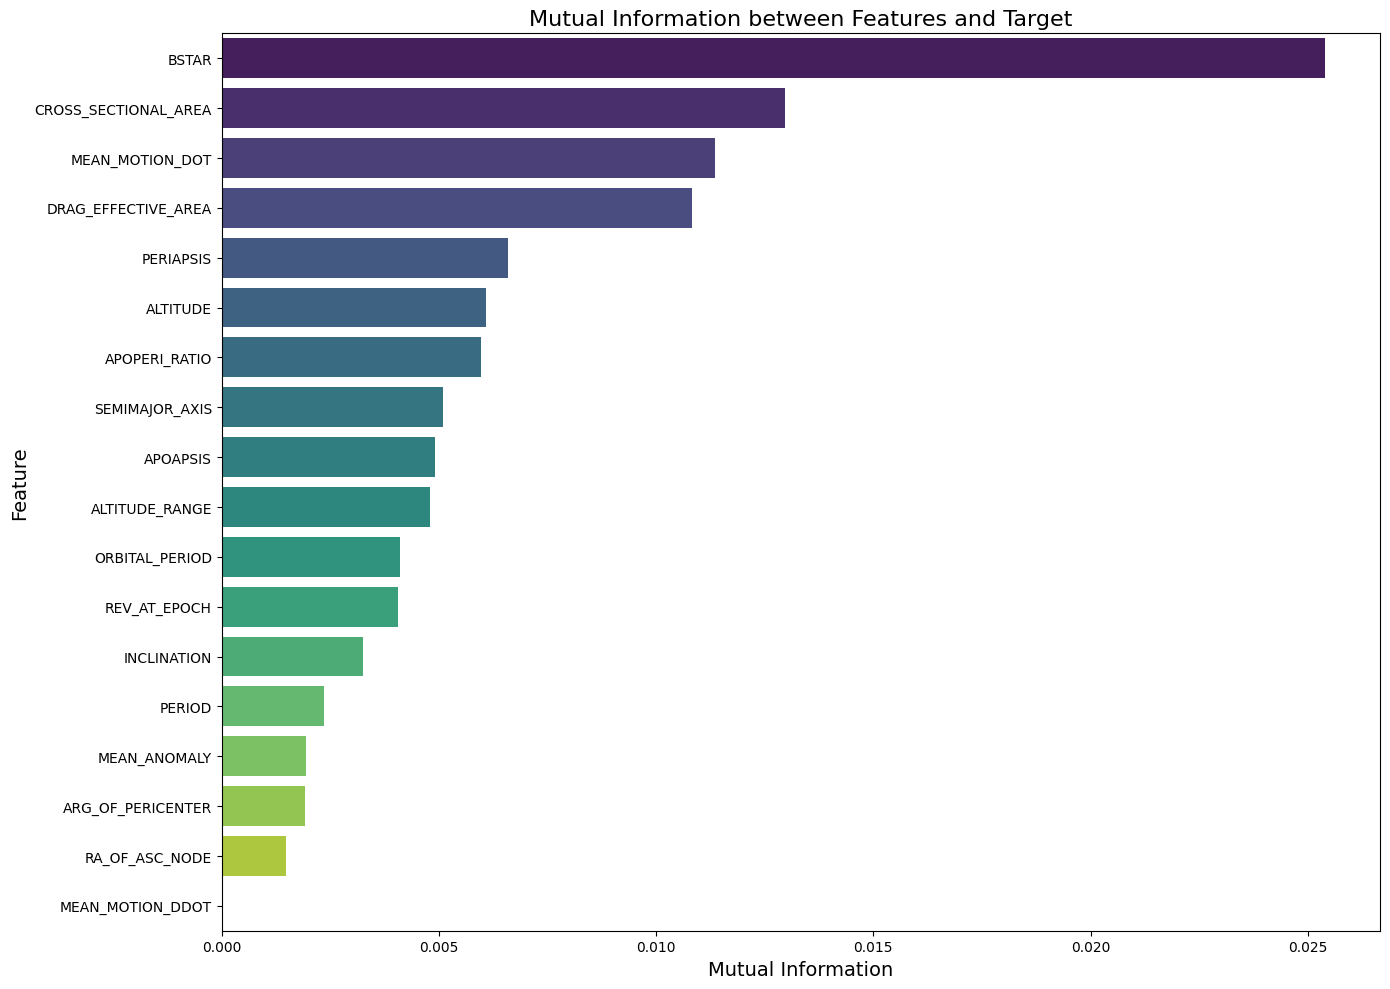

In [42]:
from sklearn.feature_selection import mutual_info_regression

x = df[columns_to_mi]
y= df['ORBITAL_DECAY_TIME']

mutual_info = mutual_info_regression(x,y)

mi_df = pd.DataFrame({'feature': x.columns, 'mutual_info': mutual_info})

mi_df = mi_df.sort_values(by='mutual_info', ascending=False)
plt.figure(figsize=(14, 10))
sns.barplot(x="mutual_info", y="feature", data=mi_df, palette='viridis')    
plt.title('Mutual Information between Features and Target', fontsize=16)
plt.xlabel('Mutual Information', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

> Mutual Information (MI) measures how much information one variable provides about another, helping to quantify the dependency between them. In the context of feature selection, it indicates how much knowing a particular feature reduces uncertainty about the target variable. Unlike simple correlation, MI is capable of capturing both linear and non-linear relationships, making it a powerful tool for identifying which features are most informative for predictive modeling.

## PCA (Principal Component Analysis: Dimensionality Reduction)

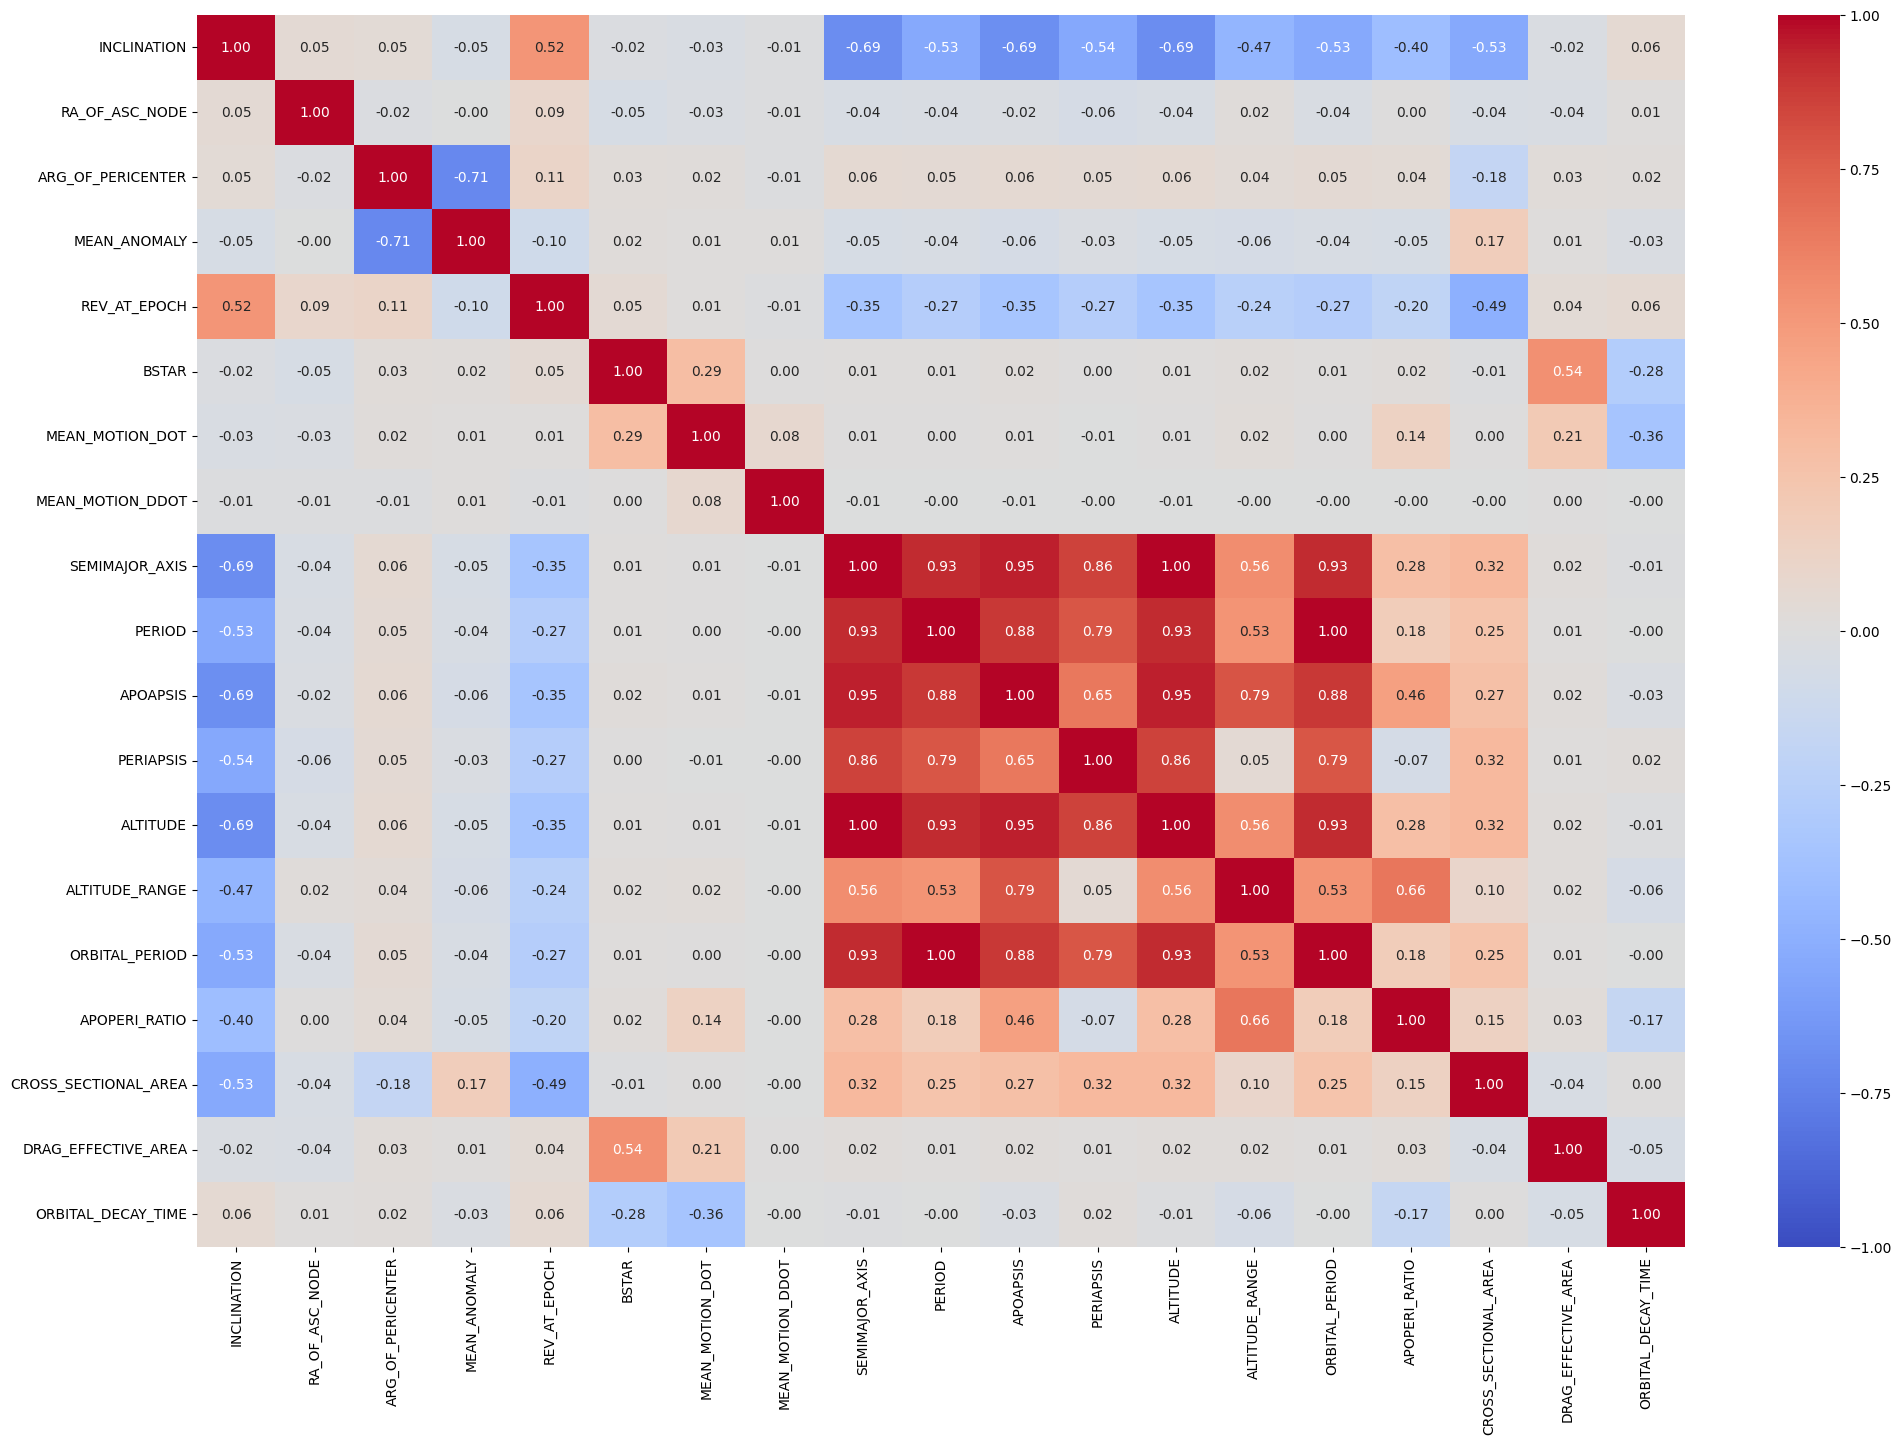

In [43]:
columns=['INCLINATION', 'RA_OF_ASC_NODE', 
                    'ARG_OF_PERICENTER', 'MEAN_ANOMALY','REV_AT_EPOCH', 'BSTAR',
                    'MEAN_MOTION_DOT','MEAN_MOTION_DDOT', 'SEMIMAJOR_AXIS', 'PERIOD',
                    'APOAPSIS', 'PERIAPSIS','ALTITUDE', 'ALTITUDE_RANGE', 'ORBITAL_PERIOD',
                    'APOPERI_RATIO','CROSS_SECTIONAL_AREA', 'DRAG_EFFECTIVE_AREA', 'ORBITAL_DECAY_TIME']
plt.figure(figsize=(24, 16))
sns.heatmap(df[columns].corr(), annot=True, cmap='coolwarm',  fmt=".2f", vmin=-1, vmax=1)
plt.show()

[0.82548469 0.97241182 1.         1.         1.         1.
 1.        ]


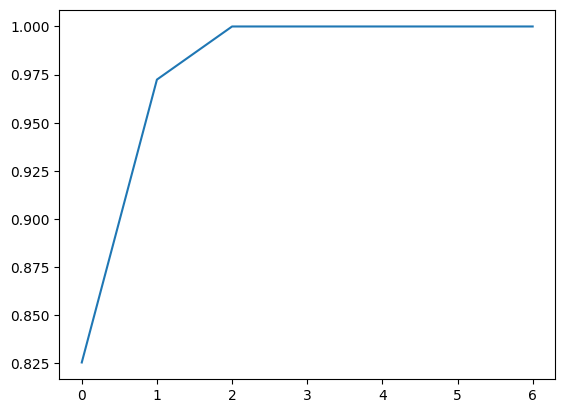

Eigenvalues of the Principal Components:
  Principal Component    Eigenvalue
0                 PC1  5.778802e+00
1                 PC2  1.028563e+00
2                 PC3  1.931310e-01
3                 PC4  2.035296e-13
4                 PC5  1.353859e-15
5                 PC6  1.238152e-16
6                 PC7  0.000000e+00


In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

multi_col = [ 'SEMIMAJOR_AXIS', 'PERIOD',
                    'APOAPSIS', 'PERIAPSIS','ALTITUDE', 'ALTITUDE_RANGE', 'ORBITAL_PERIOD']

a = df[multi_col]
a = StandardScaler().fit_transform(a)
pca = PCA()
pca_fit = pca.fit_transform(a)
print(np.cumsum(pca.explained_variance_ratio_))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

eigenvalues = pca.explained_variance_
print("Eigenvalues of the Principal Components:")
component_names = [f"PC{i+1}" for i in range(len(eigenvalues))]

eigenvalues_df = pd.DataFrame({
    "Principal Component": component_names,
    "Eigenvalue": eigenvalues   
})

eigenvalues_df = eigenvalues_df.sort_values(by='Eigenvalue', ascending=False).reset_index(drop=True)
print(eigenvalues_df)


> Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms your original features into a smaller set of uncorrelated variables called principal components, which retain most of the data’s variance. The cumulative explained variance plot shows how much total variance is captured as you add more principal components. PCA indicates strong redundancy in the original features, and dimensionality can be reduced to 2 or 3 components while preserving most of the information.

In [46]:
X_pca_df = pd.DataFrame(pca_fit, columns=component_names)
X_pca_df = X_pca_df.drop(['PC3', 'PC4', 'PC5', 'PC6', 'PC7'], axis=1)
df_wpca = pd.concat([df, X_pca_df], axis=1)
df_wpca = df_wpca.drop(multi_col, axis=1)
df_wpca.to_csv('space_decay_wpca.csv', index=False) # space_decay_wpca --> wpca: with PCA
df_wpca.head()

,OBJECT_NAME,OBJECT_ID,EPOCH,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,NORAD_CAT_ID,REV_AT_EPOCH,BSTAR,...,COUNTRY_CODE,LAUNCH_DATE,SITE,APOPERI_RATIO,CROSS_SECTIONAL_AREA,DRAG_EFFECTIVE_AREA,ESTIMATED_DECAY_EPOCH,ORBITAL_DECAY_TIME,PC1,PC2
0,ARIANE 42P+ DEB,1992-072J,2021-10-31 22:46:50.340864,7.7156,90.2410,243.1216,38.7796,26741,23588,0.024341,...,FR,1992.0,FRGUI,34.901451,0.50,0.012171,2049-03-18 22:46:50.340864,10000,2.527584,2.216555
1,SL-8 DEB,1979-028C,2021-10-31 16:32:17.360448,82.9193,299.1120,158.9093,201.3337,26743,50124,0.000066,...,CIS,1979.0,PKMTR,1.047225,0.05,0.000003,2049-03-18 16:32:17.360448,10000,-0.801242,-0.105604
2,GSAT 1,2001-015A,2021-11-01 05:22:43.421952,12.1717,16.5368,250.1248,146.2900,26745,7798,0.000000,...,IND,2001.0,SRI,1.057797,5.00,0.000000,2049-03-19 05:22:43.421952,10000,6.868320,-2.453051
3,CZ-4 DEB,1999-057MB,2021-10-31 11:11:24.198720,98.4781,8.7205,37.3771,323.1632,26754,10204,0.000316,...,PRC,1999.0,TSC,1.143078,0.05,0.000016,2049-03-18 11:11:24.198720,10000,-0.867520,-0.076275
4,CZ-4 DEB,1999-057MC,2021-10-31 17:46:46.681248,98.4232,122.0724,345.1605,27.6061,26755,9622,0.000408,...,PRC,1999.0,TSC,1.143641,0.05,0.000020,2049-03-18 17:46:46.681248,10000,-0.864285,-0.077131


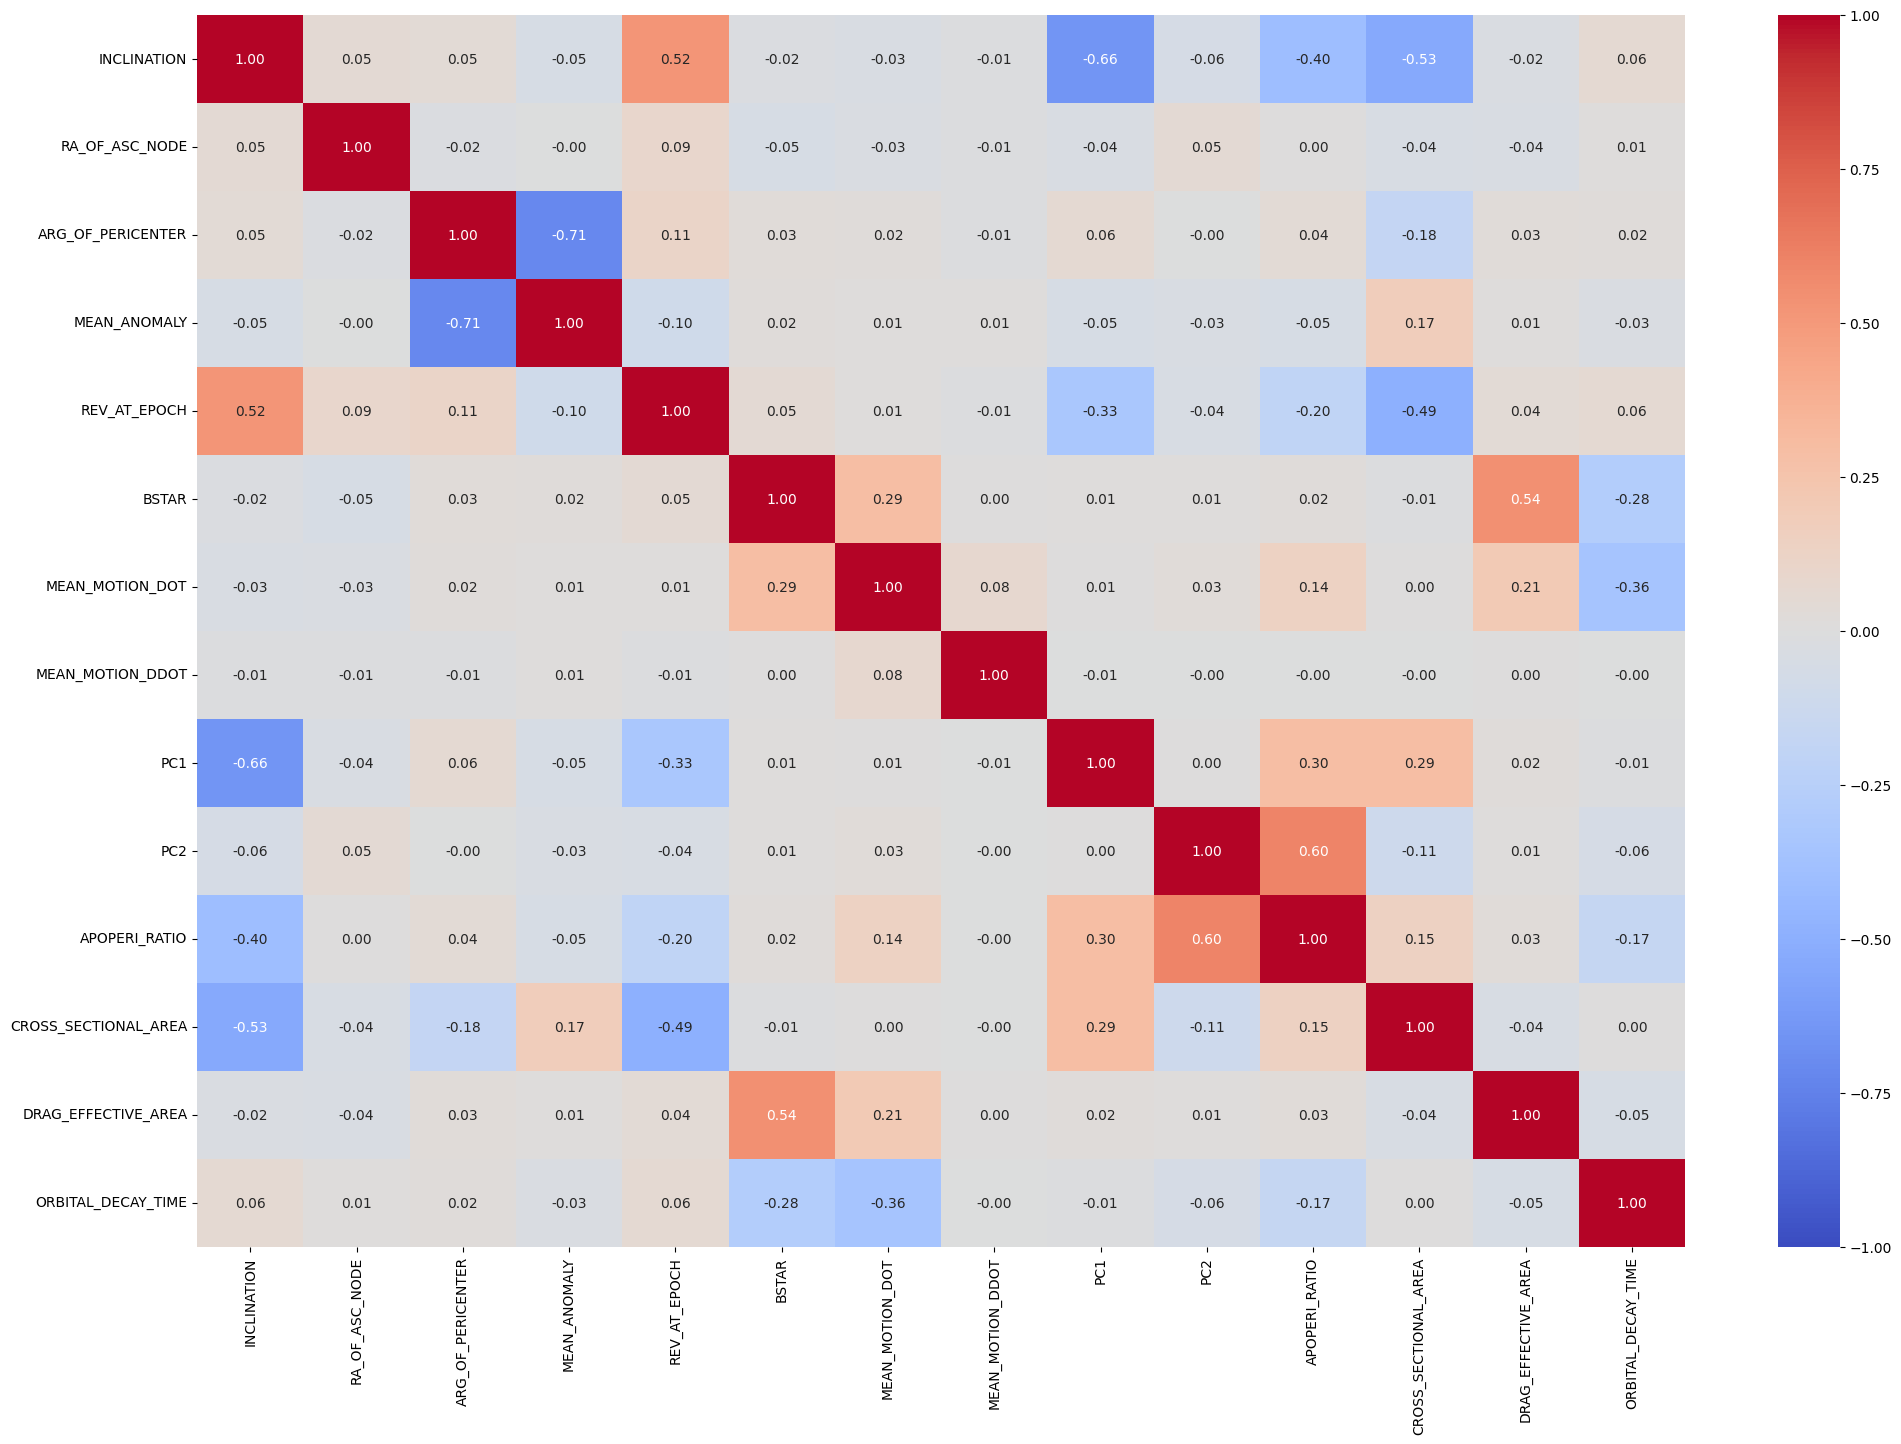

In [48]:
columns=['INCLINATION', 'RA_OF_ASC_NODE', 
                    'ARG_OF_PERICENTER', 'MEAN_ANOMALY','REV_AT_EPOCH', 'BSTAR',
                    'MEAN_MOTION_DOT','MEAN_MOTION_DDOT', 'PC1', 'PC2',
                    'APOPERI_RATIO','CROSS_SECTIONAL_AREA', 'DRAG_EFFECTIVE_AREA', 'ORBITAL_DECAY_TIME']
plt.figure(figsize=(24, 16))
sns.heatmap(df_wpca[columns].corr(), annot=True, cmap='coolwarm',  fmt=".2f", vmin=-1, vmax=1)
plt.show()

## Time Series Analysis

> I would like to clarify that my knowledge of time series analysis is limited. Therefore, I will not be training any time series models at this time. My primary objective is to present the time series analysis of my data. I acknowledge that there may be numerous aspects that require further exploration and that this section may lack comprehensive explanations. I welcome any feedback or suggestions for improvement.

In [53]:
df_wpca['ORBITAL_DECAY_TIME'].describe()  # Look for strange values


count    14125.000000
mean      9967.322973
std        492.388488
min          0.000000
25%      10000.000000
50%      10000.000000
75%      10000.000000
max      10000.000000
Name: ORBITAL_DECAY_TIME, dtype: float64

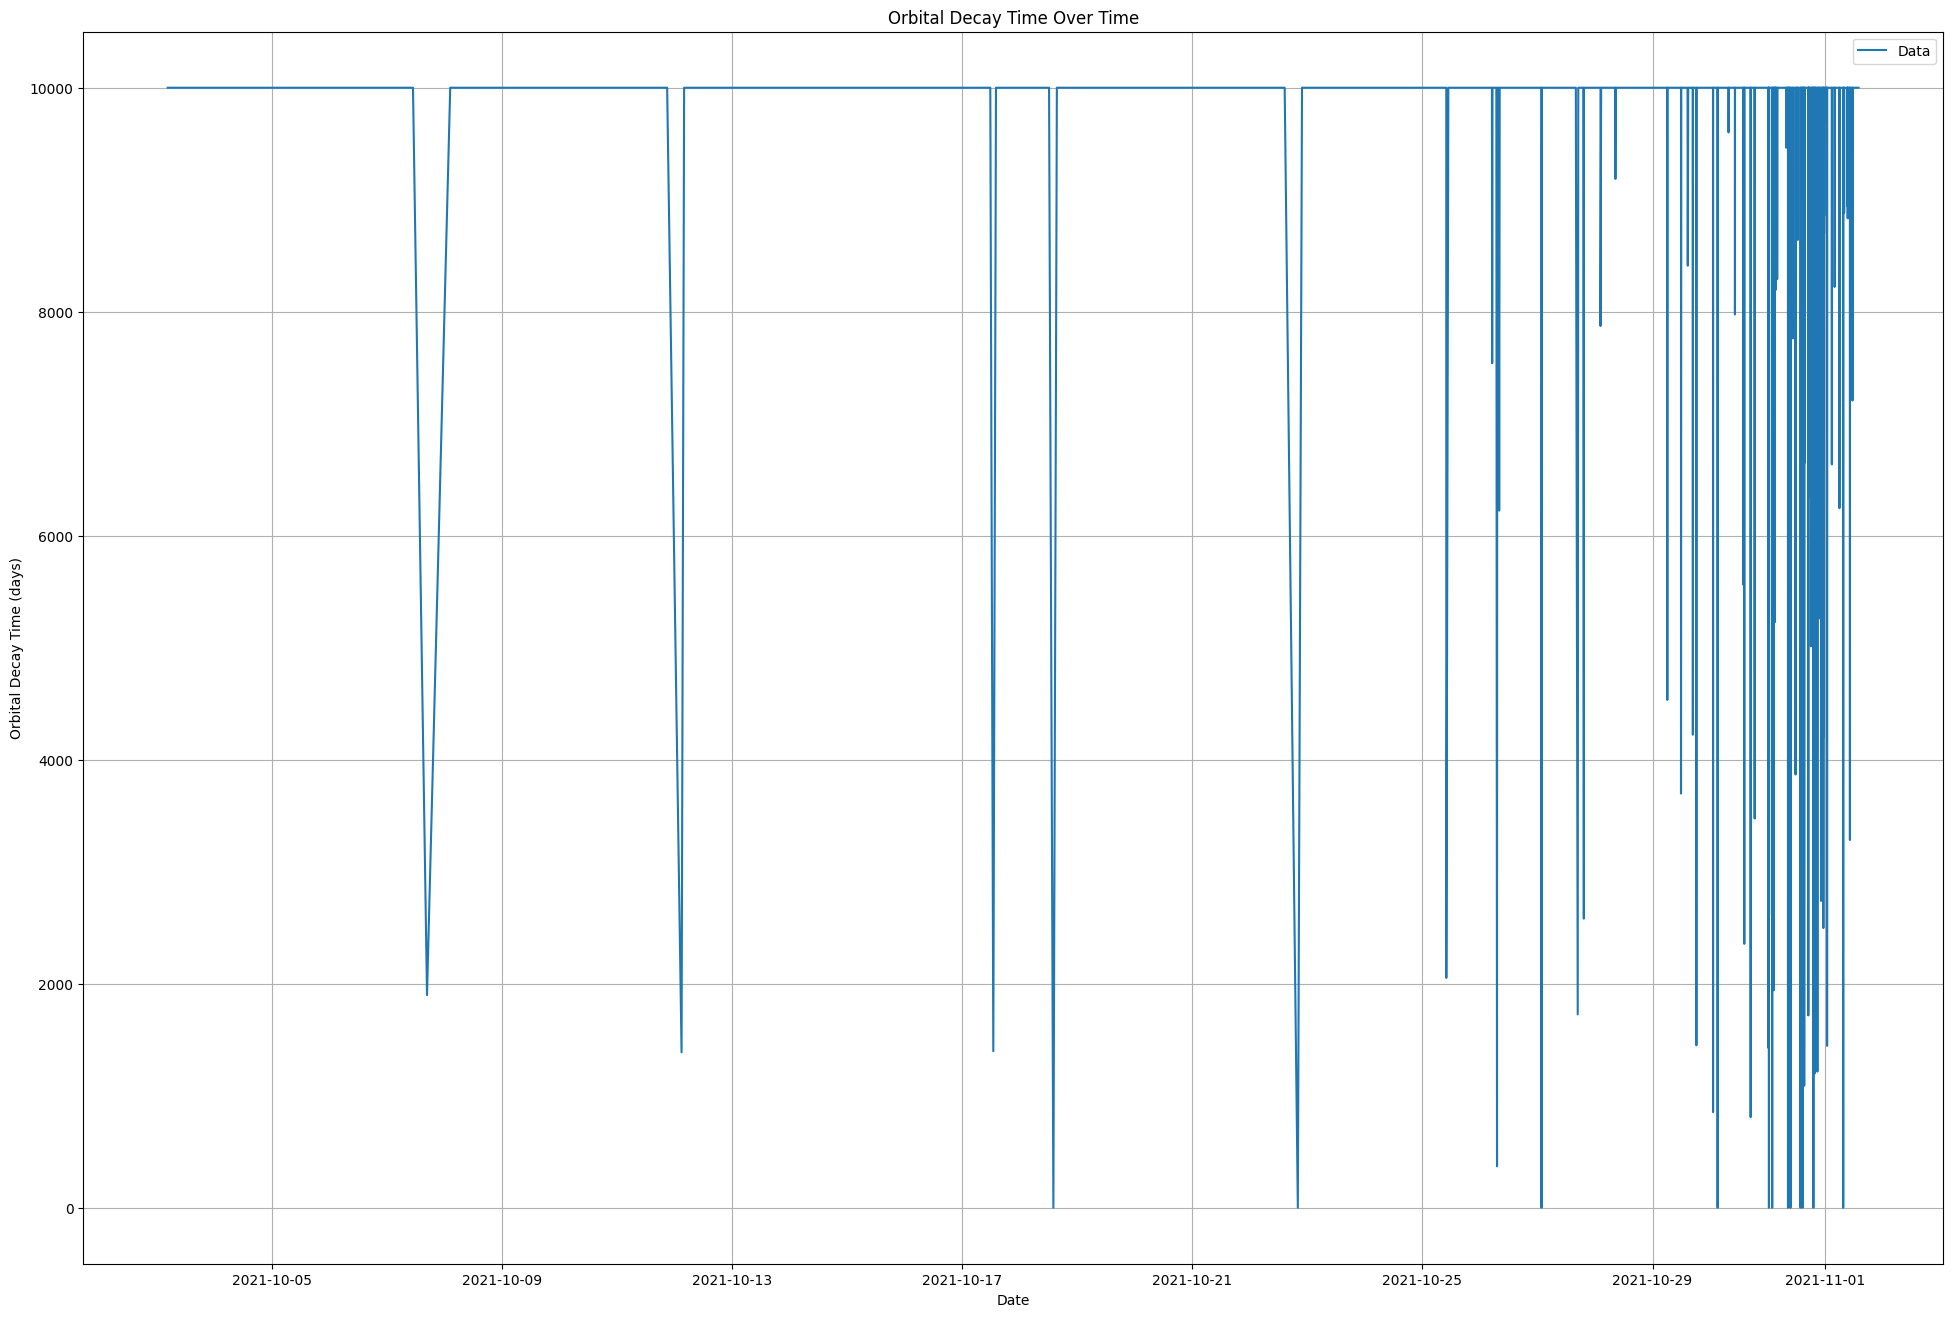

In [55]:
df_wpca.set_index('EPOCH', inplace=True)
df_wpca = df_wpca.sort_index()
plt.figure(figsize=(24, 16))
plt.plot(df_wpca.index, df_wpca['ORBITAL_DECAY_TIME'], label='Data')
plt.xlabel('Date')
plt.ylabel('Orbital Decay Time (days)')
plt.title('Orbital Decay Time Over Time')
plt.legend()
plt.grid()
plt.show()

In [54]:
df_wpca['DECAY_SMOOTHED'] = df_wpca['ORBITAL_DECAY_TIME'].rolling(window=10, center=True).mean()

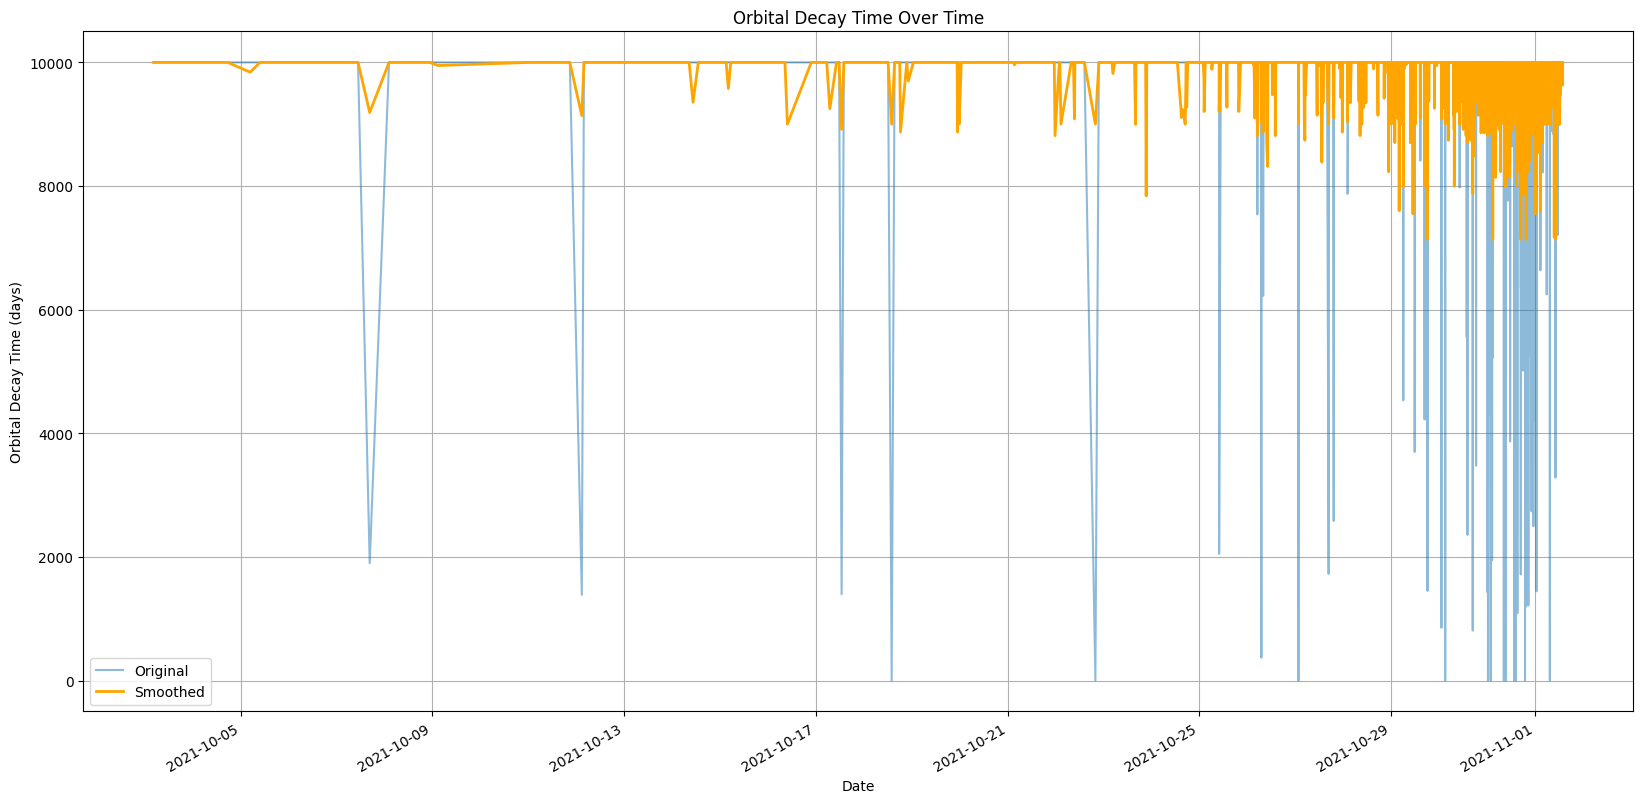

In [57]:
import matplotlib.dates as mdates

plt.figure(figsize=(20, 10))
plt.plot(df_wpca.index, df_wpca['ORBITAL_DECAY_TIME'], label='Original', alpha=0.5)
plt.plot(df_wpca.index, df_wpca['DECAY_SMOOTHED'], label='Smoothed', color='orange', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Orbital Decay Time (days)')
plt.title('Orbital Decay Time Over Time')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()


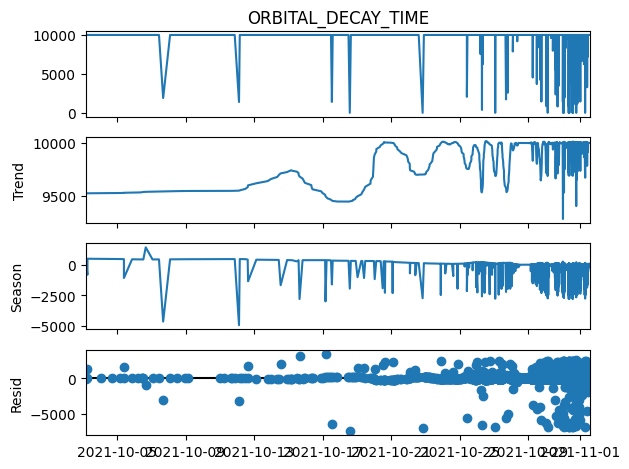

In [58]:
from statsmodels.tsa.seasonal import STL

stl = STL(df['ORBITAL_DECAY_TIME'].dropna(), period=30)
res = stl.fit()
res.plot()
plt.show()


In [59]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['ORBITAL_DECAY_TIME'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')  # p < 0.05 usually means stationary


ADF Statistic: -42.620001693360265
p-value: 0.0
